In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import json
from tqdm import tqdm
import copy
import os
import pandas as pd
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModelForCausalLM

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split

from scipy.stats import binomtest

# To ignore warnings
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

In [2]:
EPS = 1e-5
RESULTS_DIR = os.path.join(os.getcwd(), "results")

In [3]:
class Scaler():
    def __init__(self, eps=EPS):
        self.mean = None
        self.std = None
        self.eps = eps

    def fit(self, x):
        self.mean = x.mean(axis=0, keepdims=True)
        self.std = x.std(axis=0, keepdims=True)

    def normalize(self, x):
        """
        Normalizes the data x (of shape (n, d))
        """
        normalized_x = x - self.mean
        normalized_x /= (self.std + EPS)
        return normalized_x

In [4]:
class MLPProbe(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.linear1 = nn.Linear(d, 100)
        self.linear2 = nn.Linear(100, 1)

    def forward(self, x):
        h = F.relu(self.linear1(x))
        o = self.linear2(h)
        return torch.sigmoid(o)

class CCS(object):
    def __init__(self, x0, x1, nepochs=1000, ntries=50, lr=1e-3, batch_size=64, 
                 verbose=False, device="mps", linear=True, weight_decay=0.01):
        # data
        self.scaler0 = Scaler()
        self.scaler1 = Scaler()
        self.scaler0.fit(x0)
        self.scaler1.fit(x1)

        self.x0 = self.scaler0.normalize(x0)
        self.x1 = self.scaler1.normalize(x1)
        self.d = self.x0.shape[-1]

        # training
        self.nepochs = nepochs
        self.ntries = ntries
        self.lr = lr
        self.verbose = verbose
        self.device = device
        self.batch_size = batch_size
        self.weight_decay = weight_decay
        
        # probe
        self.linear = linear
        self.initialize_probe()
        self.best_probe = copy.deepcopy(self.probe)

        
    def initialize_probe(self):
        if self.linear:
            self.probe = nn.Sequential(nn.Linear(self.d, 1), nn.Sigmoid())
        else:
            self.probe = MLPProbe(self.d)
        self.probe.to(self.device)    

        
    def get_tensor_data(self):
        """
        Returns x0, x1 as appropriate tensors (rather than np arrays)
        """
        x0 = torch.tensor(self.x0, dtype=torch.float, requires_grad=False, device=self.device)
        x1 = torch.tensor(self.x1, dtype=torch.float, requires_grad=False, device=self.device)
        return x0, x1
    

    def get_loss(self, p0, p1):
        """
        Returns the CCS loss for two probabilities each of shape (n,1) or (n,)
        """
        informative_loss = (torch.min(p0, p1)**2).mean(0)
        consistent_loss = ((p0 - (1-p1))**2).mean(0)
        return informative_loss + consistent_loss


    def get_acc(self, x0_test, x1_test, y_test):
        """
        Computes accuracy for the current parameters on the given test inputs
        """
        x0 = torch.tensor(self.scaler0.normalize(x0_test), dtype=torch.float, requires_grad=False, device=self.device)
        x1 = torch.tensor(self.scaler1.normalize(x1_test), dtype=torch.float, requires_grad=False, device=self.device)
        with torch.no_grad():
            p0, p1 = self.best_probe(x0), self.best_probe(x1)
        avg_confidence = 0.5*(p0 + (1-p1))
        predictions = (avg_confidence.detach().cpu().numpy() < 0.5).astype(int)[:, 0]
        acc = (predictions == y_test).mean()
        acc = max(acc, 1 - acc)

        return acc
    
        
    def train(self):
        """
        Does a single training run of nepochs epochs
        """
        x0, x1 = self.get_tensor_data()
        permutation = torch.randperm(len(x0))
        x0, x1 = x0[permutation], x1[permutation]
        
        # set up optimizer
        optimizer = torch.optim.AdamW(self.probe.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        
        batch_size = len(x0) if self.batch_size == -1 else self.batch_size
        nbatches = len(x0) // batch_size

        # Start training (full batch)
        for epoch in range(self.nepochs):
            for j in range(nbatches):
                x0_batch = x0[j*batch_size:(j+1)*batch_size]
                x1_batch = x1[j*batch_size:(j+1)*batch_size]
            
                # probe
                p0, p1 = self.probe(x0_batch), self.probe(x1_batch)
                # get the corresponding loss
                loss = self.get_loss(p0, p1)

                # update the parameters
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        return loss.detach().cpu().item()
    
    def repeated_train(self):
        best_loss = np.inf
        for train_num in range(self.ntries):
            self.initialize_probe()
            loss = self.train()
            if loss < best_loss:
                self.best_probe = copy.deepcopy(self.probe)
                best_loss = loss

        return best_loss
    
    def predict(self, pos, neg):
        x0 = torch.tensor(self.scaler0.normalize(pos), dtype=torch.float, requires_grad=False, device=self.device)
        x1 = torch.tensor(self.scaler1.normalize(neg), dtype=torch.float, requires_grad=False, device=self.device)
        with torch.no_grad():
            p0, p1 = self.best_probe(x0), self.best_probe(x1)
        avg_confidence = 0.5*(p0 + (1-p1))
        predictions = (avg_confidence.detach().cpu().numpy() < 0.5).astype(int)[:, 0]
        return predictions

In [5]:
def unstack_prompts(data):
    return data.transpose(0, 3, 1, 2).reshape(data.shape[0] * data.shape[3], data.shape[1], data.shape[2])

def process_data(saved_names, verbose=False):
    """
    1. Loads data
    2. Stacks into numpy shape (professions x layers x dim x prompts)
    3. Undersample majority class if needed
    4. Split into train/test split across professions dim
    5. Unstacks prompts into (professions * prompts x layers x dim)
    Output shape:
        hs: (professions * prompts x layers x dim)
        y: (professions * prompts)
    """
    path = os.path.join(os.getcwd(), "saved")
    total_neg = []
    total_pos = []
    total_y = []
    # Load all results
    for saved_name in saved_names:
        root = os.path.join(path, saved_name)
        total_neg.append(np.load(os.path.join(root, "fem-hs.npy")))
        total_pos.append(np.load(os.path.join(root, "male-hs.npy")))
        total_y.append(np.load(os.path.join(root, "y.npy")))

    # Stack results on last dim
    neg_hs_layers = np.stack(total_neg, axis=-1)
    pos_hs_layers = np.stack(total_pos, axis=-1)
    y = np.stack(total_y, axis=-1)

    # Train test split
    # We want to maintain our label proportions
    neg_hs_train, neg_hs_test, pos_hs_train, pos_hs_test, y_train, y_test = train_test_split(neg_hs_layers, 
                                                                                             pos_hs_layers, 
                                                                                             y, 
                                                                                             test_size=0.2, 
                                                                                             random_state=42,
                                                                                             shuffle=True, 
                                                                                             stratify=y)
    

    # Undo stack on dim=-1 to ungroup prompts from professions
    neg_hs_train = unstack_prompts(neg_hs_train)
    neg_hs_test = unstack_prompts(neg_hs_test)
    pos_hs_train = unstack_prompts(pos_hs_train)
    pos_hs_test = unstack_prompts(pos_hs_test)
    y_train = y_train.reshape(y_train.shape[0] * y_train.shape[1])
    y_test = y_test.reshape(y_test.shape[0] * y_test.shape[1])

    if verbose:
        print(neg_hs_train.shape, pos_hs_train.shape, y_train.shape, neg_hs_test.shape, pos_hs_test.shape, y_test.shape)

    return (neg_hs_train, pos_hs_train, y_train), (neg_hs_test, pos_hs_test, y_test)

In [6]:
@ignore_warnings(category=ConvergenceWarning)
def train_lr(train_data, test_data, verbose=False):
    """
    Trains and evaluates logistic regression on difference of pos and neg hs
    Input: tuples of (neg_hs, pos_hs, y)
    """
    neg_hs_train, pos_hs_train, y_train = train_data
    neg_hs_test, pos_hs_test, y_test = test_data

    # Scale hidden states
    scaler0 = Scaler()
    scaler1 = Scaler()
    scaler0.fit(neg_hs_train)
    scaler1.fit(pos_hs_train)
    neg_hs_train = scaler0.normalize(neg_hs_train)
    pos_hs_train = scaler1.normalize(pos_hs_train)
    neg_hs_test = scaler0.normalize(neg_hs_test)
    pos_hs_test = scaler1.normalize(pos_hs_test)

    # for simplicity we can just take the difference between positive and negative hidden states
    # (concatenating also works fine)
    x_train = neg_hs_train - pos_hs_train
    lr = LogisticRegression(class_weight="balanced")
    lr.fit(x_train, y_train)
    
    x_test = neg_hs_test - pos_hs_test
    lr_pred = lr.predict(x_test)
    f1 = f1_score(y_test, lr_pred, average="weighted")
    acc = accuracy_score(y_test, lr_pred)
    if verbose:
        print(f"lr f1 score: {f1}")
        print(f"lr accuracy: {acc}")
        print(confusion_matrix(y_test, lr_pred))

    return lr, f1

In [7]:
def train_ccs(train_data, test_data, verbose=False):
    """
    Trains and evaluates ccs
    Input: tuples of (neg_hs, pos_hs, y)
    """
    neg_hs_train, pos_hs_train, y_train = train_data
    neg_hs_test, pos_hs_test, y_test = test_data

    ccs = CCS(neg_hs_train, pos_hs_train, batch_size=-1, nepochs=100)
    loss = ccs.repeated_train()

    # Normalize our test vectors
    y_pred = ccs.predict(ccs.scaler0.normalize(neg_hs_test), ccs.scaler1.normalize(pos_hs_test))
    f1 = f1_score(y_test, y_pred, average="weighted")
    acc = accuracy_score(y_test, y_pred)
    if verbose:
        print(f"ccs f1 score: {f1}")
        print(f"ccs accuracy: {acc}")
        print(confusion_matrix(y_test, y_pred))

    return ccs, f1

In [8]:
def get_baseline(y):
    class_distribution = y.sum() / len(y)
    baseline = class_distribution**2 + (1-class_distribution)**2
    return class_distribution, baseline

def plot_f1(ccs_f1s, lr_f1s, baseline=None):
    # Scatter points
    plt.scatter(range(len(ccs_f1s)), ccs_f1s, label="ccs")
    plt.scatter(range(len(lr_f1s)), lr_f1s, label="lr")
    # Horizontal line at 0.5
    if baseline:
        plt.axhline(y=baseline, color="r", linestyle="-")
    # Set range
    plt.ylim(0, 1)
    plt.title("F1 score by Layer")
    plt.xlabel("Layer")
    plt.ylabel("F1 score")
    plt.legend()
    plt.show()

In [9]:
def train_layers(saved_names: list, layers=None, verbose=False):
    """
    Trains a CCS and LR predictor for each layer of the data.
    saved names: list of saved hidden states to train on.
    layers: list of layers to train on
    Returns y so that we know the label distribution afterwards
    """
    train_data, test_data = process_data(saved_names)

    ccs_f1s = []
    lr_f1s = []

    if layers == None:
        layers = range(train_data[0].shape[1])

    for layer in tqdm(layers):
        train_layer = (train_data[0][:,layer,:], train_data[1][:,layer,:], train_data[2])
        test_layer = (test_data[0][:,layer,:], test_data[1][:,layer,:], test_data[2])
        ccs, ccs_f1 = train_ccs(train_layer, test_layer, verbose=verbose)
        l1, lr_f1 = train_lr(train_layer, test_layer, verbose=verbose)

        ccs_f1s.append(ccs_f1)
        lr_f1s.append(lr_f1)
    return ccs_f1s, lr_f1s, test_data[2]

In [10]:
def get_crowspairs_trials_by_filter(model_names, filter=None):
    """
    Generates trials in format for train function.
    Creates a trial for each model using the results for each filter.
    """
    trials = []
    for model_name in model_names:
        # Get saved hidden states appropriately based off filter
        saved_names = []
        prefix = "crowspairs/"
        if not filter:
            saved_names.append(f"crowspairs/{model_name}")
        else:
            for f in sorted(filter):
                saved_names.append(f"crowspairs/{f}/{model_name}")
            prefix += "_".join(sorted(filter))

        trial_name = f"{prefix}/{model_name}"
        trials.append({"trial_name": trial_name, "saved_names": saved_names})
    return trials


def run_trials(trials, save=True):
    """
    Runs the trials created in get_crowspairs_trials_by_filter.
    Skips a trial if results are already created for it.
    """
    # This ensures we always get the same random sample
    np.random.seed(42)
    for trial in trials:
        print(f"running trial {trial}")
        # If we already have results here, skip it
        results_path = os.path.join(RESULTS_DIR, trial["trial_name"])
        if os.path.exists(results_path):
            print(f"Already exists results for {trial['trial_name']} ")

        else:
            ccs_f1s, lr_f1s, y = train_layers(trial["saved_names"], verbose=False)
            dist, baseline = get_baseline(y)
            plot_f1(ccs_f1s, lr_f1s, baseline=baseline)

            if save:
                if not os.path.exists(results_path):
                    os.makedirs(results_path)
                np.save(os.path.join(results_path, "ccs_f1s.npy"), np.array(ccs_f1s))
                np.save(os.path.join(results_path, "lr_f1s.npy"), np.array(lr_f1s))

                with open(os.path.join(results_path, "results.txt"), "w") as f:
                    f.write(f"{trial['trial_name']}\nccs\t{max(ccs_f1s)}\nlr\t{max(lr_f1s)}")

running trial {'trial_name': 'crowspairs/age/gpt2', 'saved_names': ['crowspairs/age/gpt2']}
Already exists results for crowspairs/age/gpt2 
running trial {'trial_name': 'crowspairs/age/gpt2-medium', 'saved_names': ['crowspairs/age/gpt2-medium']}
Already exists results for crowspairs/age/gpt2-medium 
running trial {'trial_name': 'crowspairs/age/gpt2-large', 'saved_names': ['crowspairs/age/gpt2-large']}
Already exists results for crowspairs/age/gpt2-large 
running trial {'trial_name': 'crowspairs/age/gpt2-xl', 'saved_names': ['crowspairs/age/gpt2-xl']}
Already exists results for crowspairs/age/gpt2-xl 
running trial {'trial_name': 'crowspairs/age/roberta-base', 'saved_names': ['crowspairs/age/roberta-base']}


  0%|          | 0/13 [00:00<?, ?it/s]

100%|██████████| 13/13 [04:18<00:00, 19.87s/it]


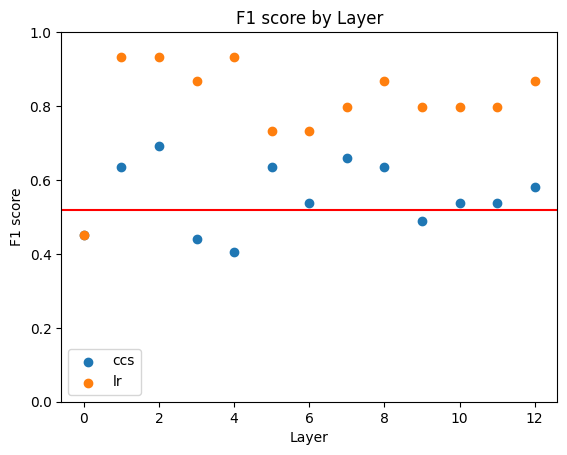

running trial {'trial_name': 'crowspairs/age/roberta-large', 'saved_names': ['crowspairs/age/roberta-large']}


100%|██████████| 25/25 [08:07<00:00, 19.49s/it]


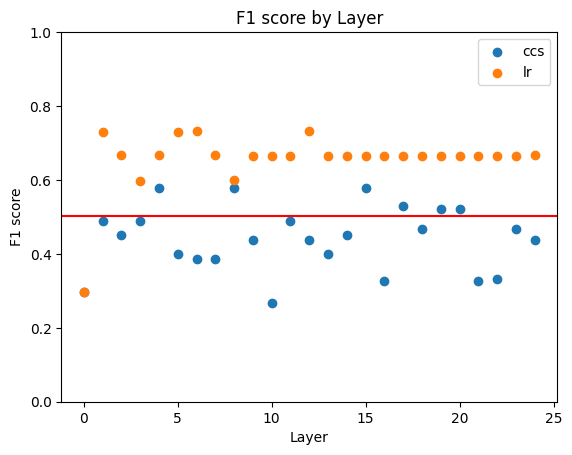

running trial {'trial_name': 'crowspairs/age/flan-t5-small', 'saved_names': ['crowspairs/age/flan-t5-small']}


100%|██████████| 9/9 [02:55<00:00, 19.48s/it]


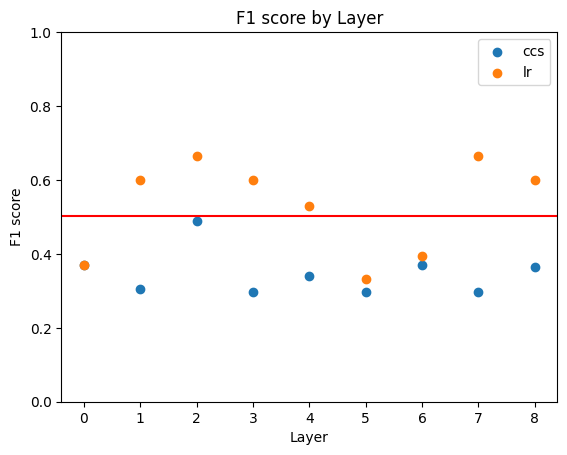

running trial {'trial_name': 'crowspairs/age/flan-t5-base', 'saved_names': ['crowspairs/age/flan-t5-base']}


100%|██████████| 13/13 [04:13<00:00, 19.48s/it]


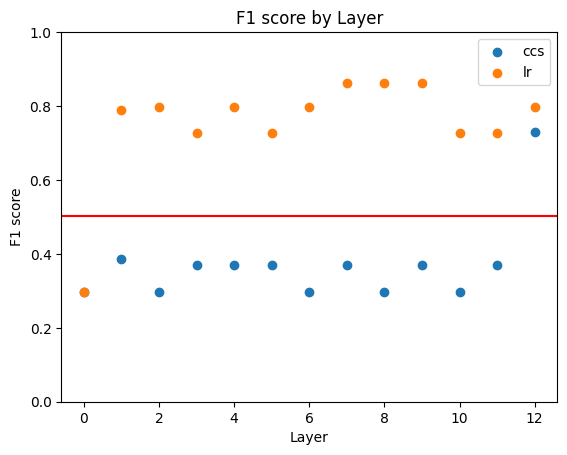

running trial {'trial_name': 'crowspairs/age/flan-t5-large', 'saved_names': ['crowspairs/age/flan-t5-large']}


100%|██████████| 25/25 [08:07<00:00, 19.50s/it]


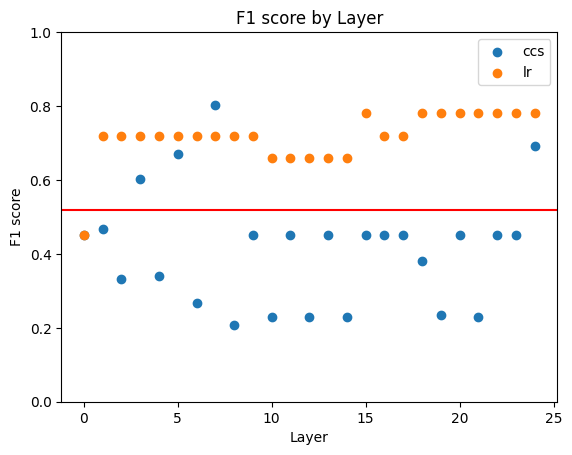

running trial {'trial_name': 'crowspairs/disability/gpt2', 'saved_names': ['crowspairs/disability/gpt2']}
Already exists results for crowspairs/disability/gpt2 
running trial {'trial_name': 'crowspairs/disability/gpt2-medium', 'saved_names': ['crowspairs/disability/gpt2-medium']}
Already exists results for crowspairs/disability/gpt2-medium 
running trial {'trial_name': 'crowspairs/disability/gpt2-large', 'saved_names': ['crowspairs/disability/gpt2-large']}
Already exists results for crowspairs/disability/gpt2-large 
running trial {'trial_name': 'crowspairs/disability/gpt2-xl', 'saved_names': ['crowspairs/disability/gpt2-xl']}
Already exists results for crowspairs/disability/gpt2-xl 
running trial {'trial_name': 'crowspairs/disability/roberta-base', 'saved_names': ['crowspairs/disability/roberta-base']}


100%|██████████| 13/13 [04:15<00:00, 19.65s/it]


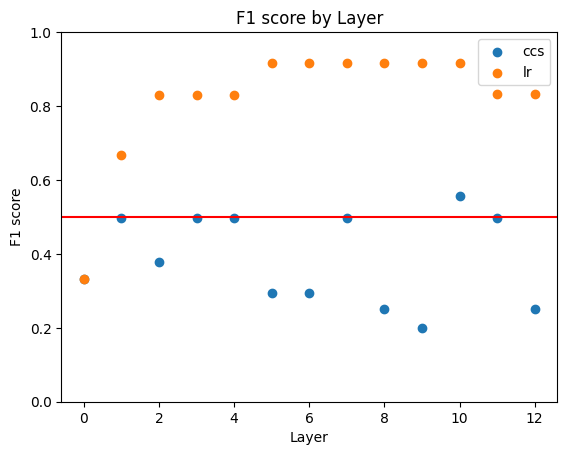

running trial {'trial_name': 'crowspairs/disability/roberta-large', 'saved_names': ['crowspairs/disability/roberta-large']}


100%|██████████| 25/25 [08:08<00:00, 19.53s/it]


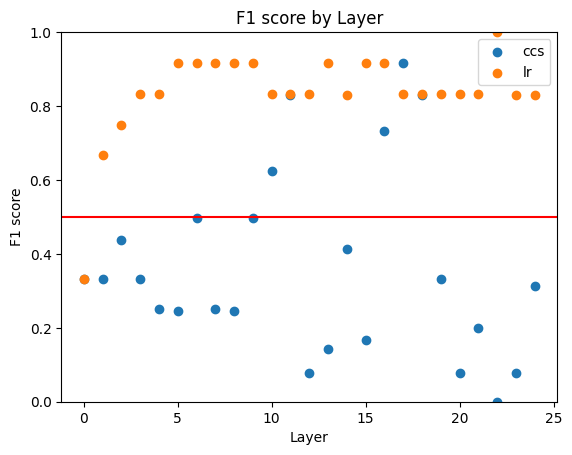

running trial {'trial_name': 'crowspairs/disability/flan-t5-small', 'saved_names': ['crowspairs/disability/flan-t5-small']}


100%|██████████| 9/9 [02:55<00:00, 19.55s/it]


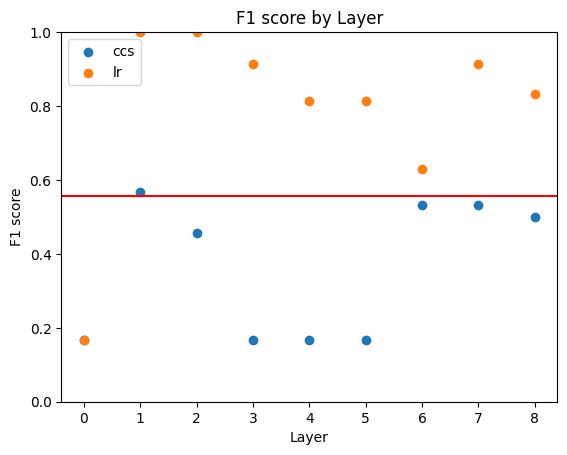

running trial {'trial_name': 'crowspairs/disability/flan-t5-base', 'saved_names': ['crowspairs/disability/flan-t5-base']}


100%|██████████| 13/13 [04:14<00:00, 19.56s/it]


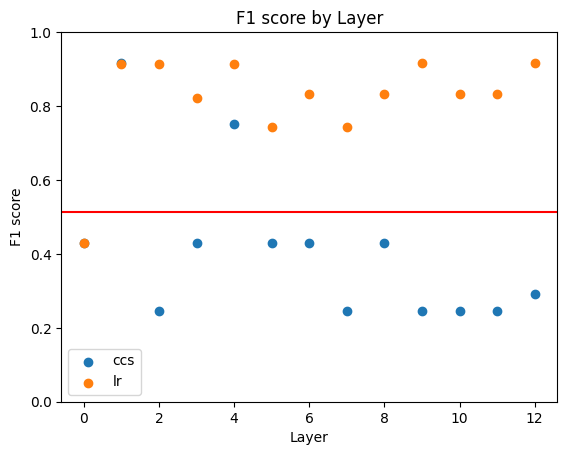

running trial {'trial_name': 'crowspairs/disability/flan-t5-large', 'saved_names': ['crowspairs/disability/flan-t5-large']}


100%|██████████| 25/25 [08:08<00:00, 19.53s/it]


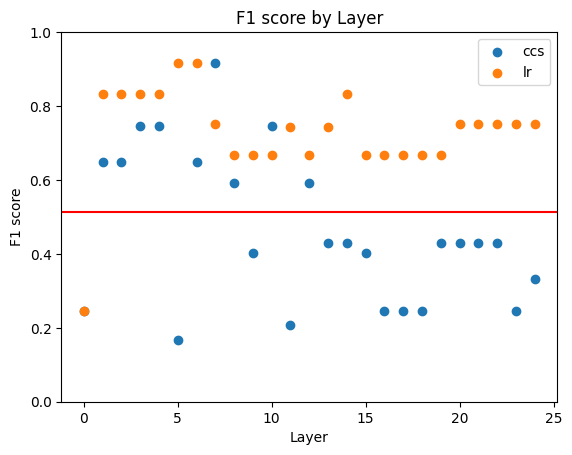

running trial {'trial_name': 'crowspairs/gender/gpt2', 'saved_names': ['crowspairs/gender/gpt2']}
Already exists results for crowspairs/gender/gpt2 
running trial {'trial_name': 'crowspairs/gender/gpt2-medium', 'saved_names': ['crowspairs/gender/gpt2-medium']}
Already exists results for crowspairs/gender/gpt2-medium 
running trial {'trial_name': 'crowspairs/gender/gpt2-large', 'saved_names': ['crowspairs/gender/gpt2-large']}
Already exists results for crowspairs/gender/gpt2-large 
running trial {'trial_name': 'crowspairs/gender/gpt2-xl', 'saved_names': ['crowspairs/gender/gpt2-xl']}
Already exists results for crowspairs/gender/gpt2-xl 
running trial {'trial_name': 'crowspairs/gender/roberta-base', 'saved_names': ['crowspairs/gender/roberta-base']}


100%|██████████| 13/13 [04:14<00:00, 19.56s/it]


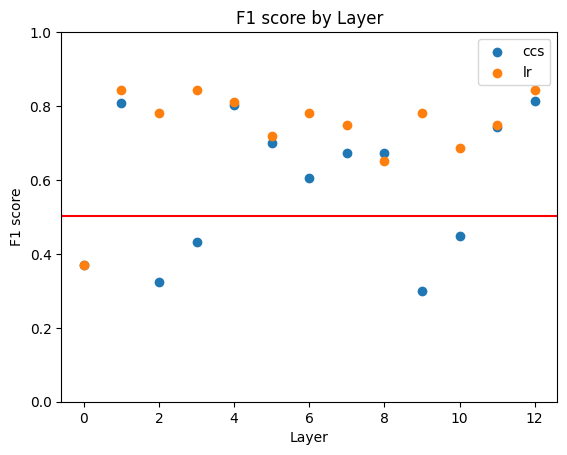

running trial {'trial_name': 'crowspairs/gender/roberta-large', 'saved_names': ['crowspairs/gender/roberta-large']}


100%|██████████| 25/25 [08:14<00:00, 19.77s/it]


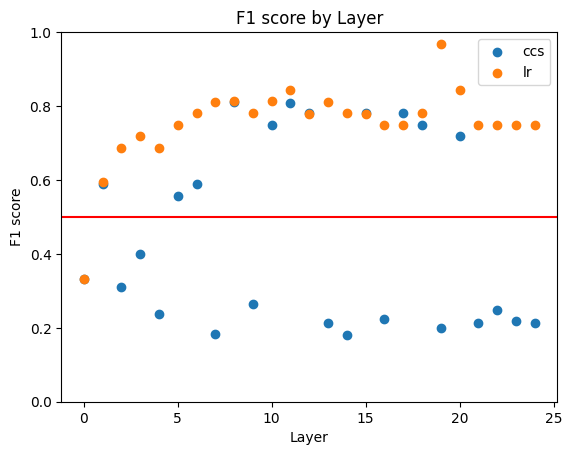

running trial {'trial_name': 'crowspairs/gender/flan-t5-small', 'saved_names': ['crowspairs/gender/flan-t5-small']}


100%|██████████| 9/9 [02:56<00:00, 19.62s/it]


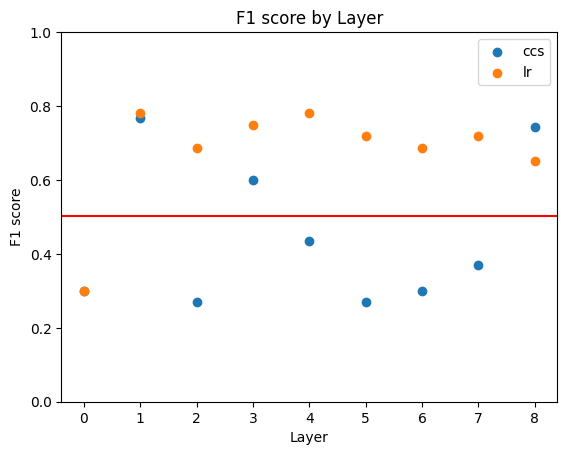

running trial {'trial_name': 'crowspairs/gender/flan-t5-base', 'saved_names': ['crowspairs/gender/flan-t5-base']}


100%|██████████| 13/13 [04:14<00:00, 19.58s/it]


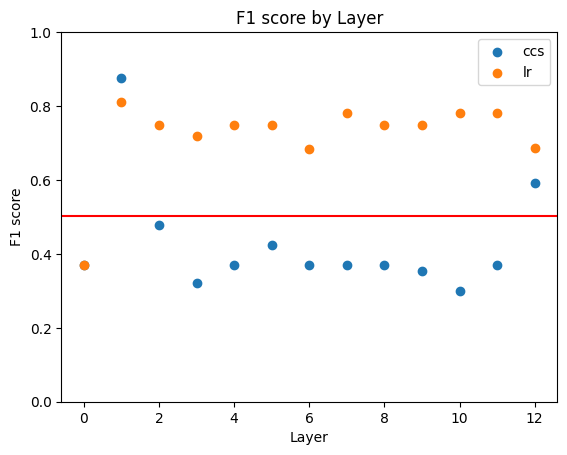

running trial {'trial_name': 'crowspairs/gender/flan-t5-large', 'saved_names': ['crowspairs/gender/flan-t5-large']}


100%|██████████| 25/25 [08:09<00:00, 19.58s/it]


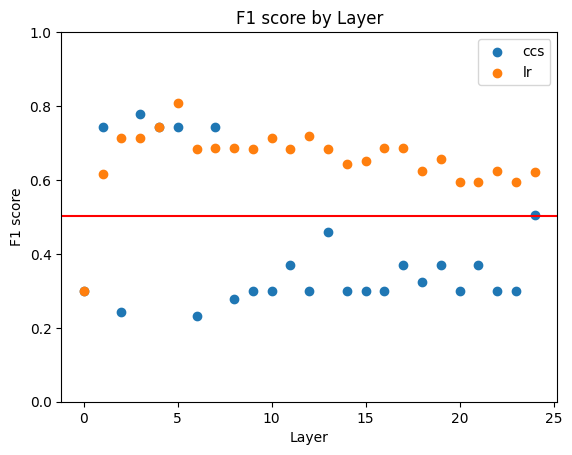

running trial {'trial_name': 'crowspairs/nationality/gpt2', 'saved_names': ['crowspairs/nationality/gpt2']}
Already exists results for crowspairs/nationality/gpt2 
running trial {'trial_name': 'crowspairs/nationality/gpt2-medium', 'saved_names': ['crowspairs/nationality/gpt2-medium']}
Already exists results for crowspairs/nationality/gpt2-medium 
running trial {'trial_name': 'crowspairs/nationality/gpt2-large', 'saved_names': ['crowspairs/nationality/gpt2-large']}
Already exists results for crowspairs/nationality/gpt2-large 
running trial {'trial_name': 'crowspairs/nationality/gpt2-xl', 'saved_names': ['crowspairs/nationality/gpt2-xl']}
Already exists results for crowspairs/nationality/gpt2-xl 
running trial {'trial_name': 'crowspairs/nationality/roberta-base', 'saved_names': ['crowspairs/nationality/roberta-base']}


100%|██████████| 13/13 [04:14<00:00, 19.59s/it]


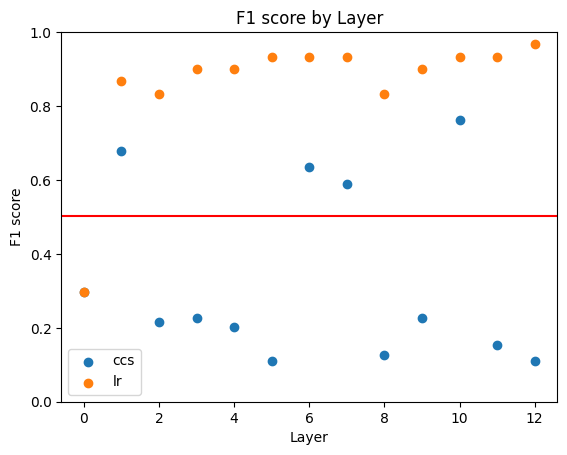

running trial {'trial_name': 'crowspairs/nationality/roberta-large', 'saved_names': ['crowspairs/nationality/roberta-large']}


100%|██████████| 25/25 [08:12<00:00, 19.68s/it]


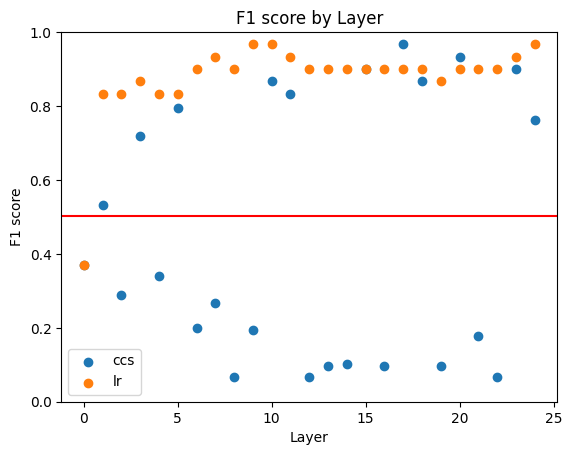

running trial {'trial_name': 'crowspairs/nationality/flan-t5-small', 'saved_names': ['crowspairs/nationality/flan-t5-small']}


100%|██████████| 9/9 [02:56<00:00, 19.64s/it]


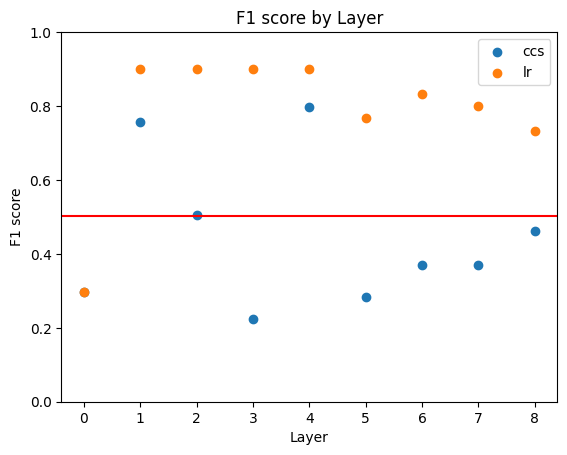

running trial {'trial_name': 'crowspairs/nationality/flan-t5-base', 'saved_names': ['crowspairs/nationality/flan-t5-base']}


100%|██████████| 13/13 [04:14<00:00, 19.61s/it]


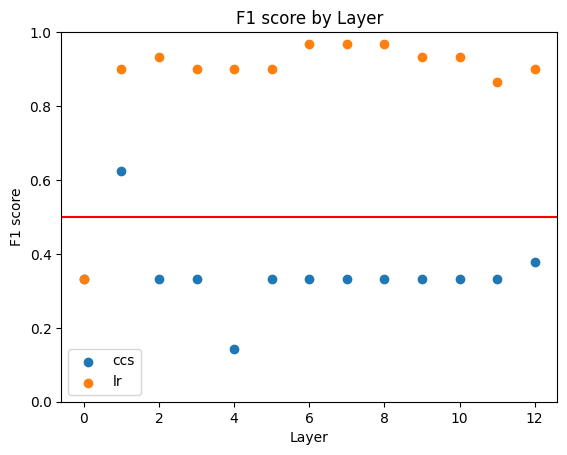

running trial {'trial_name': 'crowspairs/nationality/flan-t5-large', 'saved_names': ['crowspairs/nationality/flan-t5-large']}


100%|██████████| 25/25 [08:11<00:00, 19.65s/it]


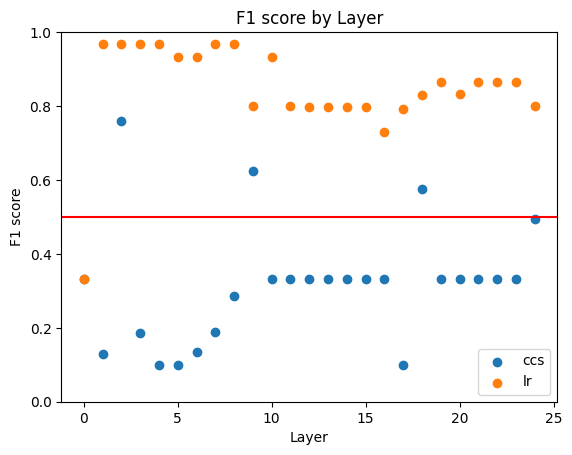

running trial {'trial_name': 'crowspairs/physical-appearance/gpt2', 'saved_names': ['crowspairs/physical-appearance/gpt2']}
Already exists results for crowspairs/physical-appearance/gpt2 
running trial {'trial_name': 'crowspairs/physical-appearance/gpt2-medium', 'saved_names': ['crowspairs/physical-appearance/gpt2-medium']}
Already exists results for crowspairs/physical-appearance/gpt2-medium 
running trial {'trial_name': 'crowspairs/physical-appearance/gpt2-large', 'saved_names': ['crowspairs/physical-appearance/gpt2-large']}
Already exists results for crowspairs/physical-appearance/gpt2-large 
running trial {'trial_name': 'crowspairs/physical-appearance/gpt2-xl', 'saved_names': ['crowspairs/physical-appearance/gpt2-xl']}
Already exists results for crowspairs/physical-appearance/gpt2-xl 
running trial {'trial_name': 'crowspairs/physical-appearance/roberta-base', 'saved_names': ['crowspairs/physical-appearance/roberta-base']}


100%|██████████| 13/13 [04:14<00:00, 19.61s/it]


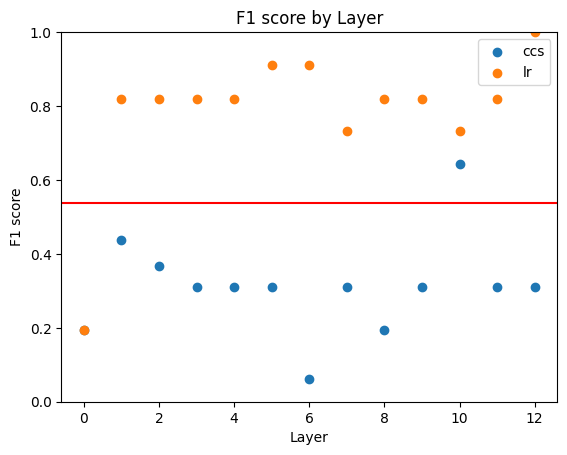

running trial {'trial_name': 'crowspairs/physical-appearance/roberta-large', 'saved_names': ['crowspairs/physical-appearance/roberta-large']}


100%|██████████| 25/25 [08:09<00:00, 19.59s/it]


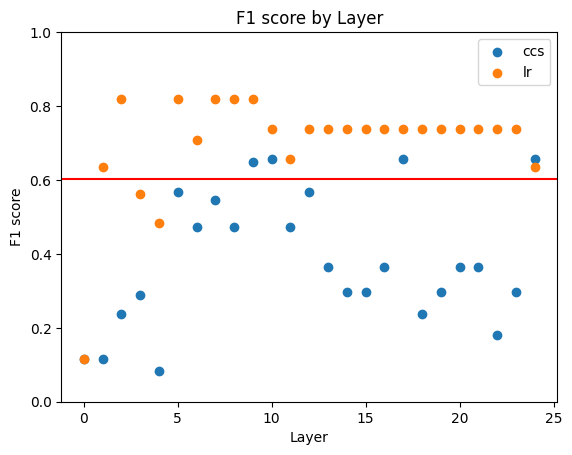

running trial {'trial_name': 'crowspairs/physical-appearance/flan-t5-small', 'saved_names': ['crowspairs/physical-appearance/flan-t5-small']}


100%|██████████| 9/9 [02:56<00:00, 19.56s/it]


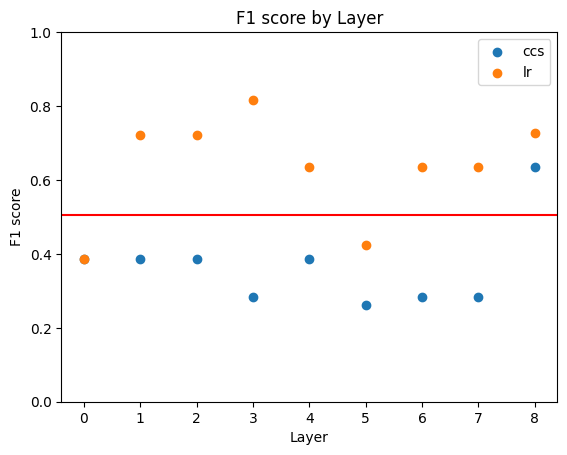

running trial {'trial_name': 'crowspairs/physical-appearance/flan-t5-base', 'saved_names': ['crowspairs/physical-appearance/flan-t5-base']}


100%|██████████| 13/13 [04:14<00:00, 19.55s/it]


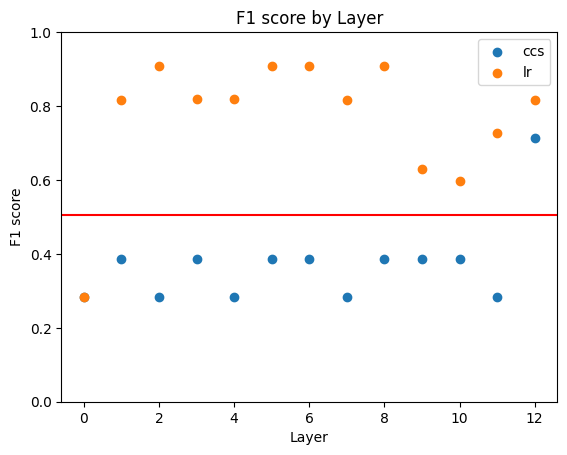

running trial {'trial_name': 'crowspairs/physical-appearance/flan-t5-large', 'saved_names': ['crowspairs/physical-appearance/flan-t5-large']}


100%|██████████| 25/25 [08:09<00:00, 19.57s/it]


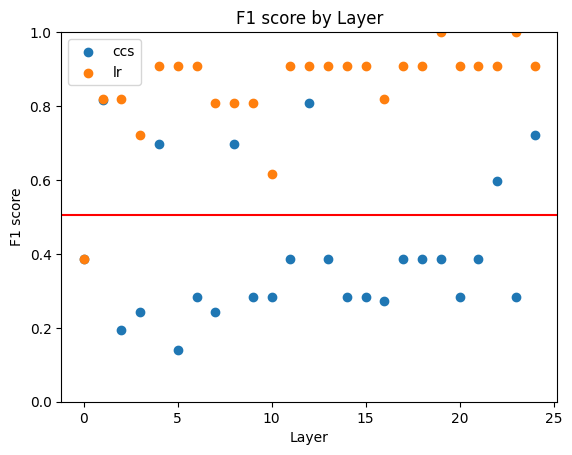

running trial {'trial_name': 'crowspairs/race-color/gpt2', 'saved_names': ['crowspairs/race-color/gpt2']}
Already exists results for crowspairs/race-color/gpt2 
running trial {'trial_name': 'crowspairs/race-color/gpt2-medium', 'saved_names': ['crowspairs/race-color/gpt2-medium']}
Already exists results for crowspairs/race-color/gpt2-medium 
running trial {'trial_name': 'crowspairs/race-color/gpt2-large', 'saved_names': ['crowspairs/race-color/gpt2-large']}
Already exists results for crowspairs/race-color/gpt2-large 
running trial {'trial_name': 'crowspairs/race-color/gpt2-xl', 'saved_names': ['crowspairs/race-color/gpt2-xl']}
Already exists results for crowspairs/race-color/gpt2-xl 
running trial {'trial_name': 'crowspairs/race-color/roberta-base', 'saved_names': ['crowspairs/race-color/roberta-base']}


100%|██████████| 13/13 [04:22<00:00, 20.17s/it]


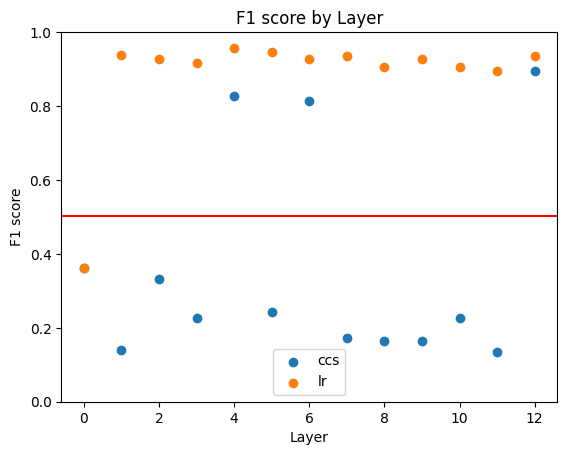

running trial {'trial_name': 'crowspairs/race-color/roberta-large', 'saved_names': ['crowspairs/race-color/roberta-large']}


100%|██████████| 25/25 [08:17<00:00, 19.90s/it]


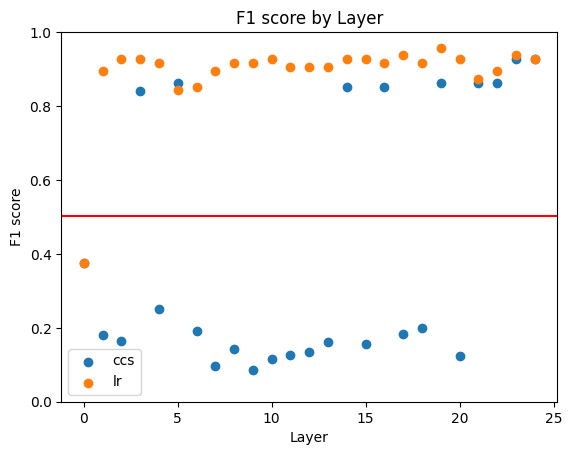

running trial {'trial_name': 'crowspairs/race-color/flan-t5-small', 'saved_names': ['crowspairs/race-color/flan-t5-small']}


100%|██████████| 9/9 [02:57<00:00, 19.68s/it]


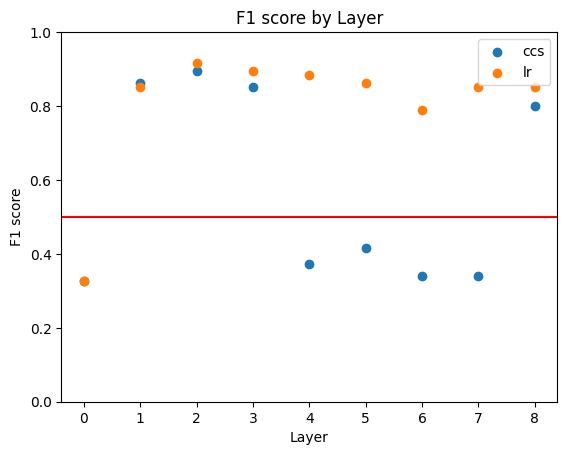

running trial {'trial_name': 'crowspairs/race-color/flan-t5-base', 'saved_names': ['crowspairs/race-color/flan-t5-base']}


100%|██████████| 13/13 [04:16<00:00, 19.70s/it]


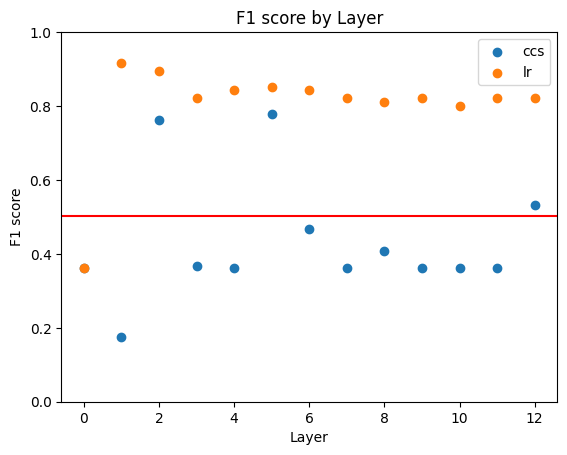

running trial {'trial_name': 'crowspairs/race-color/flan-t5-large', 'saved_names': ['crowspairs/race-color/flan-t5-large']}


100%|██████████| 25/25 [08:14<00:00, 19.78s/it]


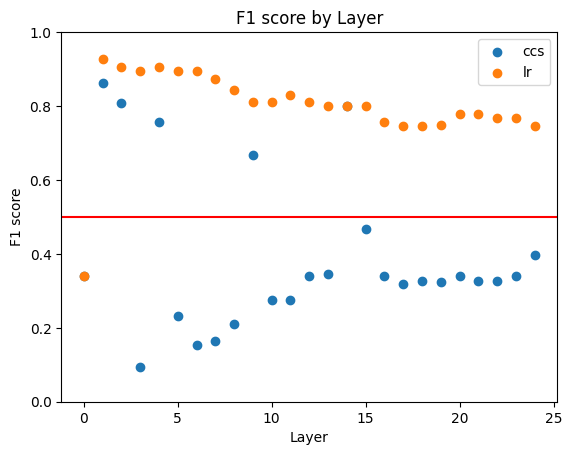

running trial {'trial_name': 'crowspairs/religion/gpt2', 'saved_names': ['crowspairs/religion/gpt2']}
Already exists results for crowspairs/religion/gpt2 
running trial {'trial_name': 'crowspairs/religion/gpt2-medium', 'saved_names': ['crowspairs/religion/gpt2-medium']}
Already exists results for crowspairs/religion/gpt2-medium 
running trial {'trial_name': 'crowspairs/religion/gpt2-large', 'saved_names': ['crowspairs/religion/gpt2-large']}
Already exists results for crowspairs/religion/gpt2-large 
running trial {'trial_name': 'crowspairs/religion/gpt2-xl', 'saved_names': ['crowspairs/religion/gpt2-xl']}
Already exists results for crowspairs/religion/gpt2-xl 
running trial {'trial_name': 'crowspairs/religion/roberta-base', 'saved_names': ['crowspairs/religion/roberta-base']}


100%|██████████| 13/13 [04:14<00:00, 19.61s/it]


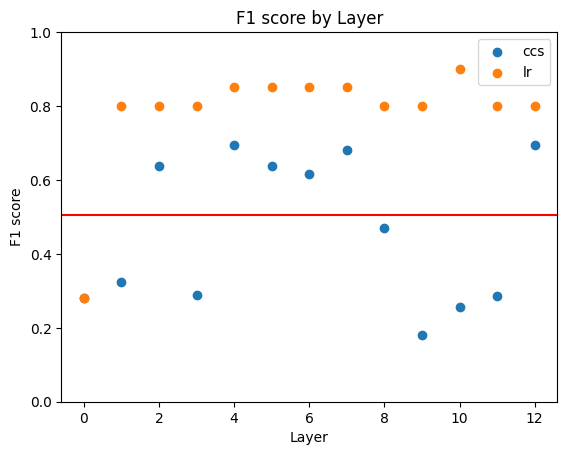

running trial {'trial_name': 'crowspairs/religion/roberta-large', 'saved_names': ['crowspairs/religion/roberta-large']}


100%|██████████| 25/25 [08:09<00:00, 19.60s/it]


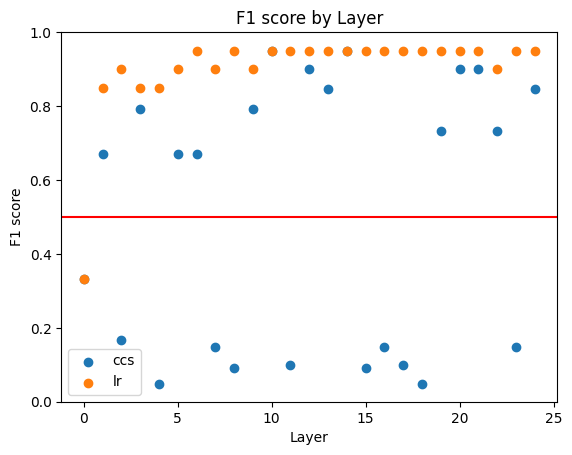

running trial {'trial_name': 'crowspairs/religion/flan-t5-small', 'saved_names': ['crowspairs/religion/flan-t5-small']}


100%|██████████| 9/9 [02:59<00:00, 19.90s/it]


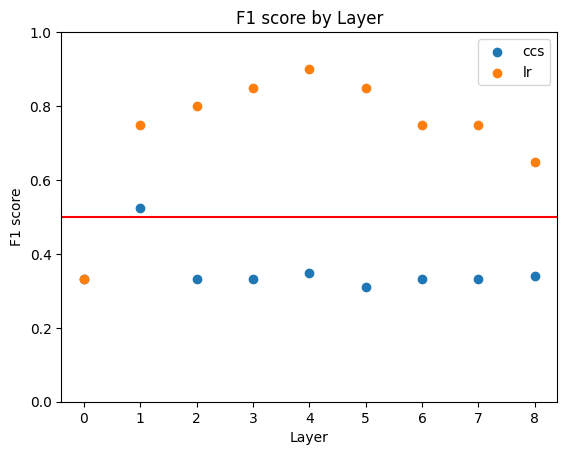

running trial {'trial_name': 'crowspairs/religion/flan-t5-base', 'saved_names': ['crowspairs/religion/flan-t5-base']}


100%|██████████| 13/13 [04:18<00:00, 19.90s/it]


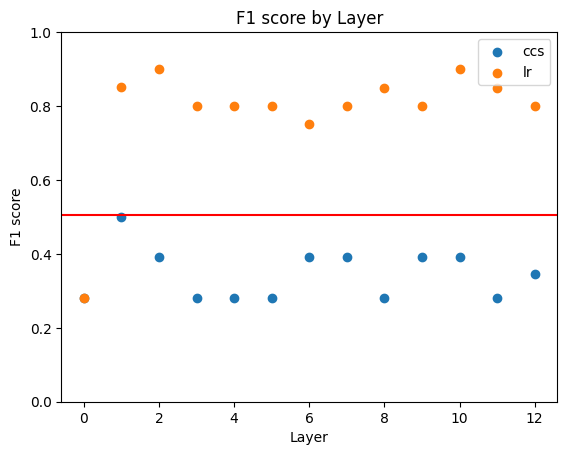

running trial {'trial_name': 'crowspairs/religion/flan-t5-large', 'saved_names': ['crowspairs/religion/flan-t5-large']}


100%|██████████| 25/25 [08:12<00:00, 19.69s/it]


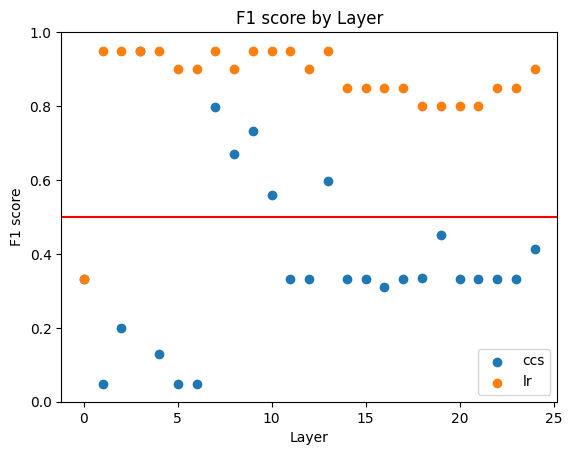

running trial {'trial_name': 'crowspairs/sexual-orientation/gpt2', 'saved_names': ['crowspairs/sexual-orientation/gpt2']}
Already exists results for crowspairs/sexual-orientation/gpt2 
running trial {'trial_name': 'crowspairs/sexual-orientation/gpt2-medium', 'saved_names': ['crowspairs/sexual-orientation/gpt2-medium']}
Already exists results for crowspairs/sexual-orientation/gpt2-medium 
running trial {'trial_name': 'crowspairs/sexual-orientation/gpt2-large', 'saved_names': ['crowspairs/sexual-orientation/gpt2-large']}
Already exists results for crowspairs/sexual-orientation/gpt2-large 
running trial {'trial_name': 'crowspairs/sexual-orientation/gpt2-xl', 'saved_names': ['crowspairs/sexual-orientation/gpt2-xl']}
Already exists results for crowspairs/sexual-orientation/gpt2-xl 
running trial {'trial_name': 'crowspairs/sexual-orientation/roberta-base', 'saved_names': ['crowspairs/sexual-orientation/roberta-base']}


100%|██████████| 13/13 [04:30<00:00, 20.77s/it]


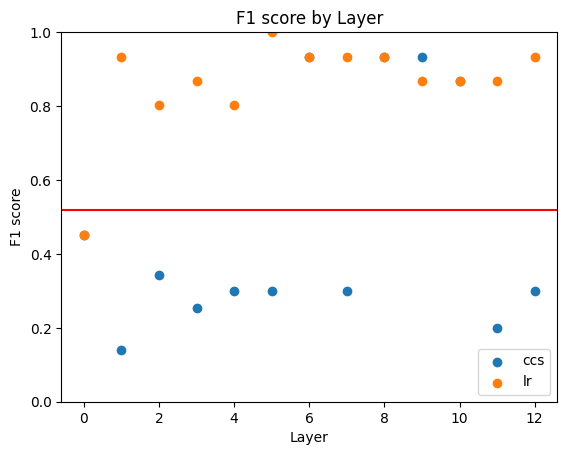

running trial {'trial_name': 'crowspairs/sexual-orientation/roberta-large', 'saved_names': ['crowspairs/sexual-orientation/roberta-large']}


100%|██████████| 25/25 [08:18<00:00, 19.92s/it]


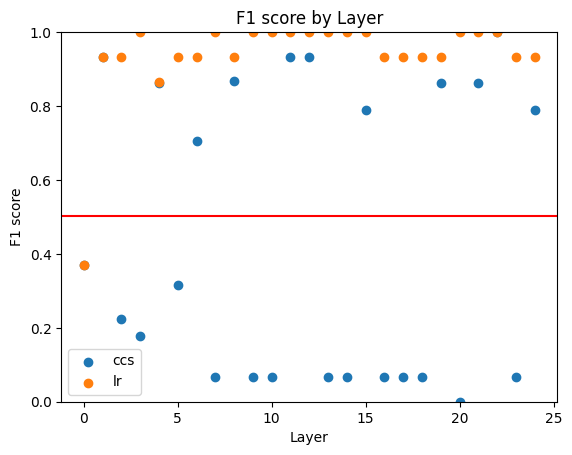

running trial {'trial_name': 'crowspairs/sexual-orientation/flan-t5-small', 'saved_names': ['crowspairs/sexual-orientation/flan-t5-small']}


100%|██████████| 9/9 [02:57<00:00, 19.70s/it]


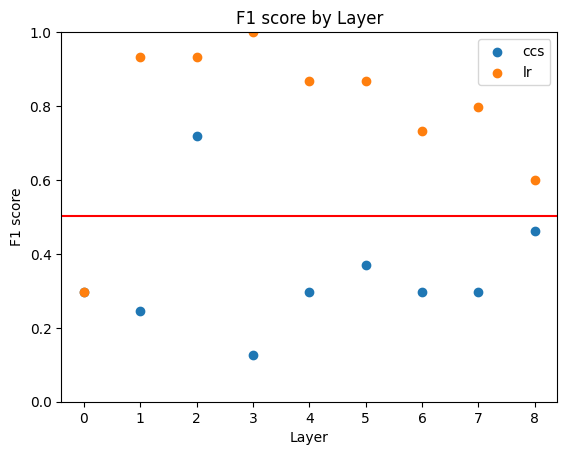

running trial {'trial_name': 'crowspairs/sexual-orientation/flan-t5-base', 'saved_names': ['crowspairs/sexual-orientation/flan-t5-base']}


100%|██████████| 13/13 [04:16<00:00, 19.74s/it]


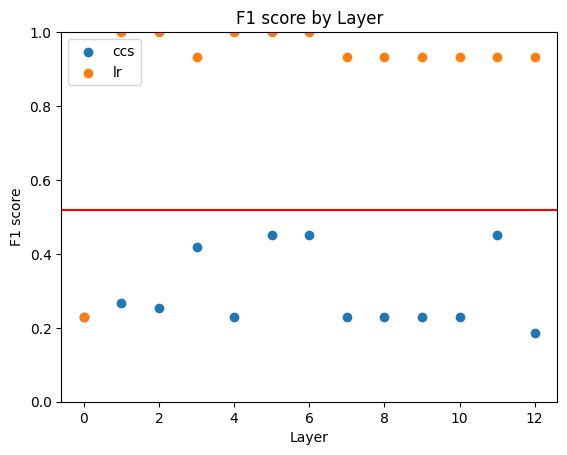

running trial {'trial_name': 'crowspairs/sexual-orientation/flan-t5-large', 'saved_names': ['crowspairs/sexual-orientation/flan-t5-large']}


100%|██████████| 25/25 [08:12<00:00, 19.69s/it]


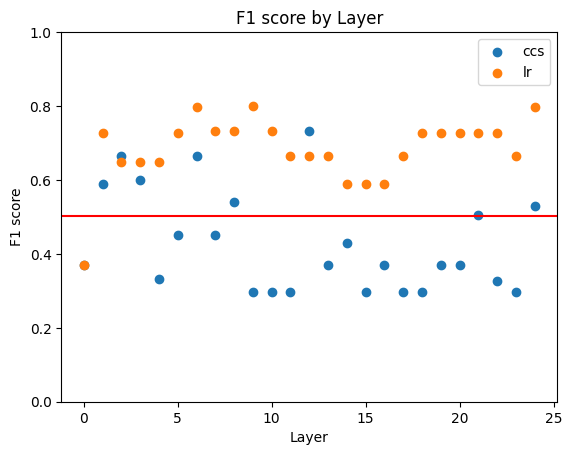

running trial {'trial_name': 'crowspairs/socioeconomic/gpt2', 'saved_names': ['crowspairs/socioeconomic/gpt2']}
Already exists results for crowspairs/socioeconomic/gpt2 
running trial {'trial_name': 'crowspairs/socioeconomic/gpt2-medium', 'saved_names': ['crowspairs/socioeconomic/gpt2-medium']}
Already exists results for crowspairs/socioeconomic/gpt2-medium 
running trial {'trial_name': 'crowspairs/socioeconomic/gpt2-large', 'saved_names': ['crowspairs/socioeconomic/gpt2-large']}
Already exists results for crowspairs/socioeconomic/gpt2-large 
running trial {'trial_name': 'crowspairs/socioeconomic/gpt2-xl', 'saved_names': ['crowspairs/socioeconomic/gpt2-xl']}
Already exists results for crowspairs/socioeconomic/gpt2-xl 
running trial {'trial_name': 'crowspairs/socioeconomic/roberta-base', 'saved_names': ['crowspairs/socioeconomic/roberta-base']}


100%|██████████| 13/13 [04:15<00:00, 19.67s/it]


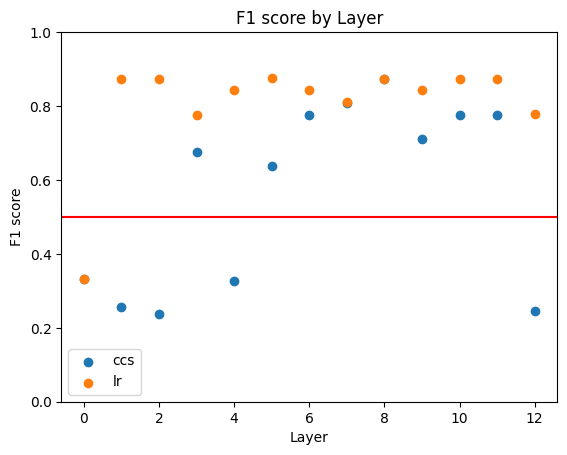

running trial {'trial_name': 'crowspairs/socioeconomic/roberta-large', 'saved_names': ['crowspairs/socioeconomic/roberta-large']}


100%|██████████| 25/25 [08:11<00:00, 19.65s/it]


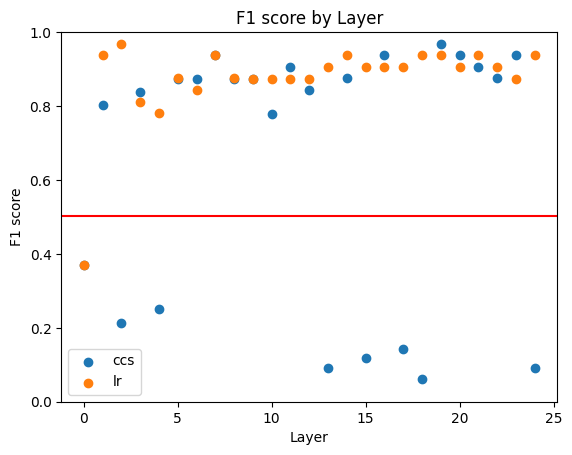

running trial {'trial_name': 'crowspairs/socioeconomic/flan-t5-small', 'saved_names': ['crowspairs/socioeconomic/flan-t5-small']}


100%|██████████| 9/9 [02:56<00:00, 19.64s/it]


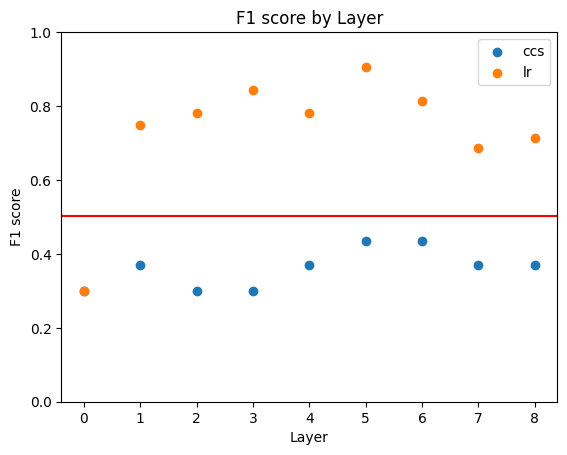

running trial {'trial_name': 'crowspairs/socioeconomic/flan-t5-base', 'saved_names': ['crowspairs/socioeconomic/flan-t5-base']}


100%|██████████| 13/13 [04:14<00:00, 19.61s/it]


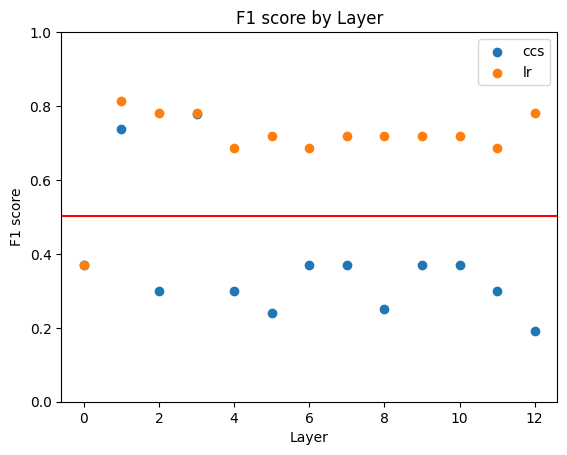

running trial {'trial_name': 'crowspairs/socioeconomic/flan-t5-large', 'saved_names': ['crowspairs/socioeconomic/flan-t5-large']}


100%|██████████| 25/25 [08:20<00:00, 20.01s/it]


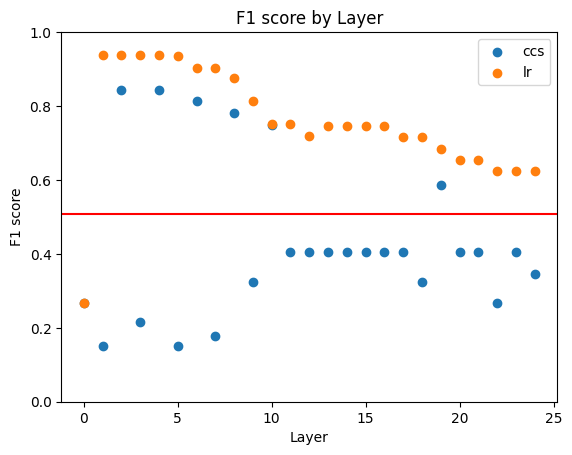

In [11]:
gpt2_models = ["gpt2", "gpt2-medium", "gpt2-large", "gpt2-xl"]
roberta_models = ["roberta-base", "roberta-large"]
flan_t5_models = ["flan-t5-small", "flan-t5-base", "flan-t5-large"]
MODEL_TYPE_LIST = [gpt2_models, roberta_models, flan_t5_models]
FILTERS = ["age", "disability", "gender", "nationality", "physical-appearance", "race-color", "religion", "sexual-orientation", "socioeconomic"]

for filter in FILTERS:
    for model_list in MODEL_TYPE_LIST:
        trials = get_crowspairs_trials_by_filter(model_list, [filter])
        run_trials(trials, save=True)